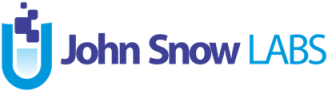

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/langtest/blob/main/demo/blogposts/Healthcare_NER_Model_Evaluation_with_LangTest.ipynb)

# Evaluating Robustness and Accuracy in Healthcare NER Models

Named Entity Recognition (NER) models play a crucial role in extracting relevant information from clinical text, enabling tasks such as medication extraction and dosage identification in healthcare.The two NER models we will examine are **ner posology** and **med7**, where both the models recognizes seven categories, including `Drug`, `Duration`, `Strength`, `Form`, `Frequency`, `Dosage`, and `Route`.

## Model Overview


1. **ner posology** - [John Snow Labs Model](https://nlp.johnsnowlabs.com/2023/07/28/ner_posology_langtest_en.html)

    The ner posology model by John Snow Labs is specifically designed for posology NER tasks in the healthcare domain. It utilizes the `embeddings_clinical` word embeddings model. This pretrained deep learning model demonstrates strong performance in extracting medication-related information from clinical text.

2. **med7** - [GitHub Repository](https://github.com/kormilitzin/med7)

    med7 is a powerful clinical NER model that offers a comprehensive solution for extracting relevant information from healthcare text. Trained on the MIMIC-III dataset, it is compatible with spaCy v3+ . The model’s details can be found in the paper titled [“Med7: a transferable clinical natural language processing model for electronic health records”](https://arxiv.org/abs/2003.01271) authored by Andrey Kormilitzin, Nemanja Vaci, Qiang Liu, and Alejo Nevado-Holgado, published as an arXiv preprint in 2020.

- To evaluate the performance and compare the robustness and Accuracy of both models, we will be using **langtest**.


## Implementation: Using the ner posology Model

**Setting up License Keys for ner_posology_langtest Model**

In [2]:
import json
import os
license_key = "spark_nlp.json"

with open(license_key) as f:
    license_keys = json.load(f)
    
locals().update(license_keys)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

**Installing Required Packages**

In [4]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

**Setting up Spark NLP and Spark Session**

In [6]:
import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline,PipelineModel
from pyspark.sql.types import StringType, IntegerType

import pandas as pd
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

params = {"spark.driver.memory":"16G",
          "spark.kryoserializer.buffer.max":"2000M",
          "spark.driver.maxResultSize":"2000M"}

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

print("Spark NLP Version :", sparknlp.version())
print("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark

Spark NLP Version : 5.0.0
Spark NLP_JSL Version : 5.0.0


The code above imports the required libraries, sets up the Spark Session, and initializes Spark NLP. Additionally, it configures parameters for Spark NLP, such as memory allocation and buffer size, to ensure optimal performance.

After running this code, you'll have the Spark Session set up with Spark NLP and be ready to proceed with utilizing the `ner_posology_langtest` model for NLP tasks.

### Define Spark NLP pipeline

To learn about the Spark NLP pipeline, you can refer to the official documentation at [Spark NLP Pipeline Documentation](https://nlp.johnsnowlabs.com/docs/en/jsl/nlp_pipes)

To process the text and extract the desired entities using the `ner_posology_langtest` model, you need to build an NLP pipeline. Run the following code to define the pipeline stages and apply the pipeline to the input text:

In [8]:
document_assembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence_detector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

clinical_ner = MedicalNerModel.pretrained("ner_posology_langtest", "en", "clinical/models")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")

ner_converter = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("ner_chunk")

nlp_pipeline = Pipeline(
    stages=[
        document_assembler, 
        sentence_detector, 
        tokenizer, 
        word_embeddings, 
        clinical_ner, 
        ner_converter
    ])

text = """The patient is a 30-year-old female with a long history of insulin dependent diabetes, type 2; coronary artery disease; chronic renal insufficiency; peripheral vascular disease, also secondary to diabetes; who was originally admitted to an outside hospital for what appeared to be acute paraplegia, lower extremities. She did receive a course of Bactrim for 14 days for UTI. Evidently, at some point in time, the patient was noted to develop a pressure-type wound on the sole of her left foot and left great toe. She was also noted to have a large sacral wound; this is in a similar location with her previous laminectomy, and this continues to receive daily care. The patient was transferred secondary to inability to participate in full physical and occupational therapy and continue medical management of her diabetes, the sacral decubitus, left foot pressure wound, and associated complications of diabetes. She is given Fragmin 5000 units subcutaneously daily, Xenaderm to wounds topically b.i.d., Lantus 40 units subcutaneously at bedtime, OxyContin 30 mg p.o. q.12 h., folic acid 1 mg daily, levothyroxine 0.1 mg p.o. daily, Prevacid 30 mg daily, Avandia 4 mg daily, Norvasc 10 mg daily, Lexapro 20 mg daily, aspirin 81 mg daily, Senna 2 tablets p.o. q.a.m., Neurontin 400 mg p.o. t.i.d., Percocet 5/325 mg 2 tablets q.4 h. p.r.n., magnesium citrate 1 bottle p.o. p.r.n., sliding scale coverage insulin, Wellbutrin 100 mg p.o. daily, and Bactrim DS b.i.d."""

data = spark.createDataFrame([[text]]).toDF("text")

result = nlp_pipeline.fit(data).transform(data)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_posology_langtest download started this may take some time.
[OK!]


To access the extracted entities from the result, you can run the following code:

In [9]:
result.select(F.explode(F.arrays_zip(result.ner_chunk.result,
                                     result.ner_chunk.metadata)).alias("cols"))\
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label")).show()

+--------------+---------+
|         chunk|ner_label|
+--------------+---------+
|       insulin|     DRUG|
|       Bactrim|     DRUG|
|   for 14 days| DURATION|
|       Fragmin|     DRUG|
|    5000 units|   DOSAGE|
|subcutaneously|    ROUTE|
|         daily|FREQUENCY|
|     topically|    ROUTE|
|         b.i.d|FREQUENCY|
|        Lantus|     DRUG|
|      40 units|   DOSAGE|
|subcutaneously|    ROUTE|
|    at bedtime|FREQUENCY|
|     OxyContin|     DRUG|
|         30 mg| STRENGTH|
|           p.o|    ROUTE|
|        q.12 h|FREQUENCY|
|    folic acid|     DRUG|
|          1 mg| STRENGTH|
|         daily|FREQUENCY|
+--------------+---------+
only showing top 20 rows



To visualize the extracted entities, you can use the `NerVisualizer` class from the `sparknlp_display` library. Run the following code:

In [11]:
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

visualiser.display(result = result.collect()[0] ,label_col = 'ner_chunk', document_col = 'document')

## Implementation: Using the med7 Model

####  Install the model:

In [12]:
# Vectors model
!pip install https://huggingface.co/kormilitzin/en_core_med7_lg/resolve/main/en_core_med7_lg-any-py3-none-any.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 607.4/607.4 MB 2.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 74.9 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 919.6/919.6 kB 126.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.7/124.7 kB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 153.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.9/492.9 kB 98.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 kB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 108.2 MB/s eta 0:00:0000:0100:01


### To utilize the `med7` model, you can follow these steps:

In [14]:
import spacy

# Load the med7 model
med7 = spacy.load("en_core_med7_lg")

# create distinct colours for labels
col_dict = {}
seven_colours = ['#e6194B', '#3cb44b', '#ffe119', '#ffd8b1', '#f58231', '#f032e6', '#42d4f4']
for label, colour in zip(med7.pipe_labels['ner'], seven_colours):
    col_dict[label] = colour

# Specify rendering options for entity visualization
options = {'ents': med7.pipe_labels['ner'], 'colors':col_dict}

# Define the input text to process
text = 'The patient is a 30-year-old female with a long history of insulin dependent diabetes, type 2; coronary artery disease; chronic renal insufficiency; peripheral vascular disease, also secondary to diabetes; who was originally admitted to an outside hospital for what appeared to be acute paraplegia, lower extremities. She did receive a course of Bactrim for 14 days for UTI. Evidently, at some point in time, the patient was noted to develop a pressure-type wound on the sole of her left foot and left great toe. She was also noted to have a large sacral wound; this is in a similar location with her previous laminectomy, and this continues to receive daily care. The patient was transferred secondary to inability to participate in full physical and occupational therapy and continue medical management of her diabetes, the sacral decubitus, left foot pressure wound, and associated complications of diabetes. She is given Fragmin 5000 units subcutaneously daily, Xenaderm to wounds topically b.i.d., Lantus 40 units subcutaneously at bedtime, OxyContin 30 mg p.o. q.12 h., folic acid 1 mg daily, levothyroxine 0.1 mg p.o. daily, Prevacid 30 mg daily, Avandia 4 mg daily, Norvasc 10 mg daily, Lexapro 20 mg daily, aspirin 81 mg daily, Senna 2 tablets p.o. q.a.m., Neurontin 400 mg p.o. t.i.d., Percocet 5/325 mg 2 tablets q.4 h. p.r.n., magnesium citrate 1 bottle p.o. p.r.n., sliding scale coverage insulin, Wellbutrin 100 mg p.o. daily, and Bactrim DS b.i.d.'

# Process the text using the med7 model
doc = med7(text)

# Visualize the entities in the text
spacy.displacy.render(doc, style='ent', jupyter=True, options=options)

[(ent.text, ent.label_) for ent in doc.ents]

[('insulin', 'DRUG'),
 ('Bactrim', 'DRUG'),
 ('for 14 days', 'DURATION'),
 ('daily', 'FREQUENCY'),
 ('Fragmin', 'DRUG'),
 ('5000 units', 'DOSAGE'),
 ('subcutaneously', 'ROUTE'),
 ('daily', 'FREQUENCY'),
 ('Xenaderm', 'DRUG'),
 ('topically', 'ROUTE'),
 ('b.i.d.', 'FREQUENCY'),
 ('Lantus', 'DRUG'),
 ('40 units', 'STRENGTH'),
 ('subcutaneously', 'ROUTE'),
 ('at bedtime', 'FREQUENCY'),
 ('OxyContin', 'DRUG'),
 ('30 mg', 'STRENGTH'),
 ('p.o.', 'ROUTE'),
 ('q.12 h.', 'FREQUENCY'),
 ('folic acid', 'DRUG'),
 ('1 mg', 'STRENGTH'),
 ('daily', 'FREQUENCY'),
 ('levothyroxine', 'DRUG'),
 ('0.1 mg', 'STRENGTH'),
 ('p.o.', 'ROUTE'),
 ('daily', 'FREQUENCY'),
 ('Prevacid', 'DRUG'),
 ('30 mg', 'STRENGTH'),
 ('daily', 'FREQUENCY'),
 ('Avandia', 'DRUG'),
 ('4 mg', 'STRENGTH'),
 ('daily', 'FREQUENCY'),
 ('Norvasc', 'DRUG'),
 ('10 mg', 'STRENGTH'),
 ('daily', 'FREQUENCY'),
 ('Lexapro', 'DRUG'),
 ('20 mg', 'STRENGTH'),
 ('daily', 'FREQUENCY'),
 ('aspirin', 'DRUG'),
 ('81 mg', 'STRENGTH'),
 ('daily', 'FREQUEN

# Evaluating Model Performance with LangTest

Now that we have introduced the two prominent NER healthcare models, **ner posology** and **med7**, it is essential to evaluate and test their performance. Evaluating these models allows us to understand their strengths, weaknesses, and overall suitability for extracting relevant information from clinical text. To accomplish this, we will utilize the **LangTest**.

## LangTest

**LangTest** is an open-source Python library designed to help developers deliver safe and effective Natural Language Processing (NLP) models. Whether you are using models from **John Snow Labs**, **Hugging Face**, **spaCy**, or LLMs from **OpenAI**, **Cohere**, **AI21**, **Hugging Face Inference API**, or **Azure-OpenAI**, LangTest has got you covered. It provides a comprehensive set of tests for evaluating Named Entity Recognition (NER), Text Classification, Question-Answering, and Summarization models. The library supports over 50 out-of-the-box tests, categorized into robustness, accuracy, bias, representation, and fairness.


### Evaluation Metrics

To thoroughly assess the performance and compare the **Robustness** and **Accuracy** of the `ner posology` and `med7` models, we will employ the LangTest Python library. LangTest provides a wide range of tests for evaluating NER models, including Robustness and Accuracy.

#### Robustness Testing

Model robustness can be described as the ability of a model to keep similar levels of accuracy, precision and recall when perturbations are made to the data it is predicting on. For example, in the case of NER, the goal is to understand how documents with typos or fully uppercased sentences affect the model's prediction performance compared to documents similar to those in the original training set.


**`Supported Robustness tests :`**<br>


- **`uppercase`**: capitalization of the test set is turned into uppercase

- **`lowercase`**: capitalization of the test set is turned into lowercase

- **`titlecase`**: capitalization of the test set is turned into title case

- **`add_punctuation`**: special characters at end of each sentence are replaced by other special characters, if no
special character at the end, one is added

- **`strip_punctuation`**: special characters are removed from the sentences (except if found in numbers, such as '2.5')

- **`add_typo`**: typos are introduced in sentences

- **`add_contraction`**: contractions are added where possible (e.g. 'do not' contracted into 'don't')

- **`add_context`**: tokens are added at the beginning and at the end of the sentences

- **`swap_entities`**: named entities replaced with same entity type with same token count from terminology

- **`swap_cohyponyms`**: Named entities replaced with co-hyponym from the WordNet database

- **`american_to_british`**: American English will be changed to British English

- **`british_to_american`**: British English will be changed to American English

- **`number_to_word`**: Converts numeric values in sentences to their equivalent verbal representation.

- **`add_ocr_typo`**: Ocr typos are introduced in sentences

- **`multiple_perturbations`** : Transforms the given sentences by applying multiple perturbations in a specific sequence.

- **`add_speech_to_text_typo`**: Introduce common conversion errors from SSpeech to Text conversion.

- **`add_abbreviation`**:Replaces words or expressions in texts with their abbreviations

- **`adjective_synonym_swap`** : Transforms the adjectives in the given sentences to their synonyms.

- **`adjective_antonym_swap`** : Transforms the adjectives in the given sentences to their antonyms.

<br/>

<br/>


#### Accuracy Testing

Accuracy testing is a crucial step in evaluating the performance of a machine learning model. It involves measuring how well the model can correctly predict outcomes on a test dataset, which it has not seen before. The accuracy of a model is determined by comparing its predicted output with the actual output. To support the accuracy testing process, several accuracy tests are available. These tests aim to evaluate various aspects of a model's performance both labelwise such as its precision, recall, F1 score and overall like micro F1 score, macro F1 score, and weighted F1 score.


**`Supported Accuracy tests :`**

- **`min_precision_score`**: Determine if the actual precision score is less than the desired precision score.

- **`min_recall_score`**:  Determine if the actual recall score is less than the desired recall score.

- **`min_f1_score`**: Determine if the actual f1 score is less than the desired f1 score.

- **`min_micro_f1_score`**:  Determine if the actual micro-f1 score is less than the desired micro-f1 score.

- **`min_macro_f1_score`**:  Determine if the actual macro-f1 score is less than the desired macro-f1 score.

- **`min_weighted_f1_score`**:  Determine if the actual min-weighted-f1 score is less than the desired min-weighted-f1 score.


To use LangTest, you can install it using pip

In [15]:
# Installing LangTest version 1.3.0
!pip install langtest==1.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 33.9 MB/s eta 0:00:0000:010:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 141.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 132.5 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.1
    Uninstalling tqdm-4.64.1:
      Successfully uninstalled tqdm-4.64.1
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.12
    Uninstalling pydantic-1.10.12:
      Successfully uninstalled pydantic-1.10.12
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3


### Harness and its Parameters

The Harness class is a testing class for Natural Language Processing (NLP) models. It evaluates the performance of a NLP model on a given task using test data and generates a report with test results.Harness can be imported from the LangTest library in the following way.

In [16]:
from langtest import Harness

It imports the Harness class from within the module, that is designed to provide a blueprint or framework for conducting NLP testing, and that instances of the Harness class can be customized or configured for different testing scenarios or environments.

Here is a list of the different parameters that can be passed to the Harness function:

<br/>



| Parameter     | Description |
| ------------- | ----------- |
| **task**      | Task for which the model is to be evaluated (text-classification or ner) |
| **model**     | Specifies the model(s) to be evaluated. Can be a dictionary or a list of dictionaries. Each dictionary should contain 'model' and 'hub' keys. If a path is specified, the dictionary must contain 'model' and 'hub' keys. |
| **data**      | The data to be used for evaluation. A dictionary providing flexibility and options for data sources. It should include the following keys: <ul><li>data_source (mandatory): The source of the data.</li><li>subset (optional): The subset of the data.</li><li>feature_column (optional): The column containing the features.</li><li>target_column (optional): The column containing the target labels.</li><li>split (optional): The data split to be used.</li></ul> |
| **config**    | Configuration for the tests to be performed, specified in the form of a YAML file. |


<br/>
<br/>

### Test Configuration

Test configuration can be passed in the form of a YAML file as shown below or using .configure() method


**Config YAML format** :
```
tests:     
  defaults:
    min_pass_rate: 0.65
  robustness:
    add_typo:
      min_pass_rate: 0.66
    uppercase:
      min_pass_rate: 0.62
  
```

If config file is not present, we can also use the **.configure()** method to manually configure the harness to perform the needed tests.

## Testing the ner_posology_langtest Model

In [17]:
# John Snow Labs setup
!pip install johnsnowlabs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.0/499.0 kB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 133.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.4/95.4 kB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 641.3/641.3 kB 101.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 34.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for databricks-cli: filename=databricks_cli-0.17.7-py3-none-any.whl size=143861 sha256=607442f865323a69a074f4e0f046723b7de4db4f2c6a11875e8deea38d8ef66c
  Stored in directory: /home/jovyan/.cache/pip/wheels/ae/63/93/5402c1a09c1868a59d0b05013484e07af97a9d7b3dbd5bd39a
Successfully built databricks-cli
  Attempting uninstall: spark-nlp
    Found existing installation: spark-nlp 5.0.0
    Uninstalling spark-nlp-5.0.0:
      Successfully uninstalled spark-nlp-5

#### Define Spark NLP pipeline

In [18]:
document_assembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence_detector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
	.setInputCols(["sentence", "token"])\
	.setOutputCol("embeddings")

clinical_ner = MedicalNerModel.pretrained("ner_posology_langtest")\
 .setInputCols(["sentence","token","embeddings"])\
 .setOutputCol("ner")

ner_converter = NerConverterInternal()\
 	.setInputCols(["sentence", "token", "ner"])\
 	.setOutputCol("ner_chunk")

nlp_pipeline = Pipeline(stages=[document_assembler, sentence_detector, tokenizer, word_embeddings, clinical_ner, ner_converter])

ner_posology_langtest = nlp_pipeline.fit(spark.createDataFrame([[""]]).toDF("text"))

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_posology_langtest download started this may take some time.
[OK!]


#### Instantiate the Harness Class
We start by instantiating the Harness class and providing the necessary information for testing. In this case, we specify the test data, set the task to "ner", and provide the model name and hub information.

In [21]:
harness = Harness(
            task = "ner",
            data={"data_source":"sample-test.conll"},
            model={"model":ner_posology_langtest,"hub":"johnsnowlabs"}
        )

Test Configuration : 
 {
 "tests": {
  "defaults": {
   "min_pass_rate": 1.0
  },
  "robustness": {
   "add_typo": {
    "min_pass_rate": 0.7
   },
   "american_to_british": {
    "min_pass_rate": 0.7
   }
  },
  "accuracy": {
   "min_micro_f1_score": {
    "min_score": 0.7
   }
  },
  "bias": {
   "replace_to_female_pronouns": {
    "min_pass_rate": 0.7
   },
   "replace_to_low_income_country": {
    "min_pass_rate": 0.7
   }
  },
  "fairness": {
   "min_gender_f1_score": {
    "min_score": 0.6
   }
  },
  "representation": {
   "min_label_representation_count": {
    "min_count": 50
   }
  }
 }
}


#### Configure the Tests
We can use the .configure() method to manually configure the tests we want to perform.

In [22]:
harness.configure(
{
 'tests': {'defaults': {'min_pass_rate': 0.70},
           'robustness': {'uppercase': {'min_pass_rate': 0.70},
                          'lowercase': {'min_pass_rate': 0.70},
                          'titlecase':{'min_pass_rate': 0.70},
                          'add_punctuation':{'min_pass_rate': 0.70},
                          'strip_punctuation':{'min_pass_rate': 0.70},
                          'add_slangs':{'min_pass_rate': 0.70},
                          'dyslexia_word_swap':{'min_pass_rate': 0.70},
                          'add_abbreviation':{'min_pass_rate': 0.70},
                          'add_speech_to_text_typo':{'min_pass_rate': 0.70},
                          'number_to_word':{'min_pass_rate': 0.70},
                          'add_ocr_typo':{'min_pass_rate': 0.70},
                          'adjective_synonym_swap':{'min_pass_rate': 0.70}
                        },
              'accuracy': {'min_precision_score': {'min_score': 0.70},
                          'min_recall_score':{'min_score': 0.70},
                        'min_f1_score':{'min_score': 0.70},
                        'min_micro_f1_score':{'min_score': 0.70}
                          }
          }
 }
)

{'tests': {'defaults': {'min_pass_rate': 0.7},
  'robustness': {'uppercase': {'min_pass_rate': 0.7},
   'lowercase': {'min_pass_rate': 0.7},
   'titlecase': {'min_pass_rate': 0.7},
   'add_punctuation': {'min_pass_rate': 0.7},
   'strip_punctuation': {'min_pass_rate': 0.7},
   'add_slangs': {'min_pass_rate': 0.7},
   'dyslexia_word_swap': {'min_pass_rate': 0.7},
   'add_abbreviation': {'min_pass_rate': 0.7},
   'add_speech_to_text_typo': {'min_pass_rate': 0.7},
   'number_to_word': {'min_pass_rate': 0.7},
   'add_ocr_typo': {'min_pass_rate': 0.7},
   'adjective_synonym_swap': {'min_pass_rate': 0.7}},
  'accuracy': {'min_precision_score': {'min_score': 0.7},
   'min_recall_score': {'min_score': 0.7},
   'min_f1_score': {'min_score': 0.7},
   'min_micro_f1_score': {'min_score': 0.7}}}}

Here we have configured the harness to perform robustness and Accuracy tests. For each test category, we have specified the minimum pass rates and additional parameters where applicable.

#### Generating the test cases.

In [ ]:
harness.generate()

Generating testcases...: 100%|██████████| 2/2 [00:00<00:00, 13662.23it/s]


harness.generate() method automatically generates the test cases (based on the provided configuration)

In [ ]:
harness.testcases()

harness.testcases() method gives the produced test cases in form of a pandas data frame.

#### Running the tests

In [ ]:
harness.run()

Running testcases... : 100%|██████████| 18025/18025 [38:22<00:00,  7.83it/s]  


Called after harness.generate() and is to used to run all the tests.  Returns a pass/fail flag for each test.

#### Generated Results

In [ ]:
harness.generated_results()

,category,test_type,original,test_case,expected_result,actual_result,pass
0,robustness,uppercase,"Once adequate arrhythmia control is achieved , or if side effects become prominent , reduce amiodarone hydrochloride dose to 600 to 800 mg/day for one month and then to the maintenance dose , usua...","ONCE ADEQUATE ARRHYTHMIA CONTROL IS ACHIEVED , OR IF SIDE EFFECTS BECOME PROMINENT , REDUCE AMIODARONE HYDROCHLORIDE DOSE TO 600 TO 800 MG/DAY FOR ONE MONTH AND THEN TO THE MAINTENANCE DOSE , USUA...","amiodarone hydrochloride: DRUG, 600 to 800 mg/day: STRENGTH, for one month: DURATION, 400 mg/day: STRENGTH","AMIODARONE HYDROCHLORIDE: DRUG, 600 TO 800 MG/DAY: STRENGTH, FOR ONE MONTH: DURATION, 400 MG/DAY: STRENGTH",True
1,robustness,uppercase,One applicator full of VANDAZOLE administered intravaginally once a day for 5 days .,ONE APPLICATOR FULL OF VANDAZOLE ADMINISTERED INTRAVAGINALLY ONCE A DAY FOR 5 DAYS .,"VANDAZOLE: DRUG, intravaginally: ROUTE, once a day: FREQUENCY, for 5 days: DURATION","VANDAZOLE: DRUG, INTRAVAGINALLY: ROUTE, ONCE A DAY: FREQUENCY, FOR 5 DAYS: DURATION",True
2,robustness,uppercase,"Because of the potential for gastric irritation ( see WARNINGS ), Potassium Chloride Extended-release Capsules , USP , 8 mEq and 10 mEq should be taken with meals and with a full glass of water or...","BECAUSE OF THE POTENTIAL FOR GASTRIC IRRITATION ( SEE WARNINGS ), POTASSIUM CHLORIDE EXTENDED-RELEASE CAPSULES , USP , 8 MEQ AND 10 MEQ SHOULD BE TAKEN WITH MEALS AND WITH A FULL GLASS OF WATER OR...","Potassium Chloride Extended-release: DRUG, Capsules: FORM, 8 mEq: STRENGTH, 10 mEq: STRENGTH, with meals: FREQUENCY","POTASSIUM CHLORIDE EXTENDED-RELEASE: DRUG, CAPSULES: FORM, 8 MEQ: STRENGTH",False
3,robustness,uppercase,DOSAGE AND ADMINISTRATION : Selegiline hydrochloride capsules are intended for administration to Parkinsonian patients receiving levodopa/carbidopa therapy who demonstrate a deteriorating response...,DOSAGE AND ADMINISTRATION : SELEGILINE HYDROCHLORIDE CAPSULES ARE INTENDED FOR ADMINISTRATION TO PARKINSONIAN PATIENTS RECEIVING LEVODOPA/CARBIDOPA THERAPY WHO DEMONSTRATE A DETERIORATING RESPONSE...,"Selegiline hydrochloride: DRUG, capsules: FORM, levodopa/carbidopa: DRUG","SELEGILINE HYDROCHLORIDE: DRUG, CAPSULES: FORM, LEVODOPA/CARBIDOPA: DRUG",True
4,robustness,uppercase,Directions For sunscreen use : - apply liberally and evenly 15 minutes before sun exposure - reapply at least every 2 hours - use a water resistant sunscreen if swimming or sweating - Sun Protecti...,DIRECTIONS FOR SUNSCREEN USE : - APPLY LIBERALLY AND EVENLY 15 MINUTES BEFORE SUN EXPOSURE - REAPPLY AT LEAST EVERY 2 HOURS - USE A WATER RESISTANT SUNSCREEN IF SWIMMING OR SWEATING - SUN PROTECTI...,at least every 2 hours: FREQUENCY,,False
...,...,...,...,...,...,...,...
18020,accuracy,min_f1_score,-,DURATION,0.7,0.860147,True
18021,accuracy,min_f1_score,-,ROUTE,0.7,0.878648,True
18022,accuracy,min_f1_score,-,DOSAGE,0.7,0.707101,True
18023,accuracy,min_f1_score,-,FREQUENCY,0.7,0.925128,True


This method returns the generated results in the form of a pandas dataframe, which provides a convenient and easy-to-use format for working with the test results. You can use this method to quickly identify the test cases that failed and to determine where fixes are needed.

In [ ]:
df= harness.generated_results()

#### Generated Results For robustness

In [ ]:
df[df["category"]=="robustness"]

,category,test_type,original,test_case,expected_result,actual_result,pass
0,robustness,uppercase,"Once adequate arrhythmia control is achieved , or if side effects become prominent , reduce amiodarone hydrochloride dose to 600 to 800 mg/day for one month and then to the maintenance dose , usua...","ONCE ADEQUATE ARRHYTHMIA CONTROL IS ACHIEVED , OR IF SIDE EFFECTS BECOME PROMINENT , REDUCE AMIODARONE HYDROCHLORIDE DOSE TO 600 TO 800 MG/DAY FOR ONE MONTH AND THEN TO THE MAINTENANCE DOSE , USUA...","amiodarone hydrochloride: DRUG, 600 to 800 mg/day: STRENGTH, for one month: DURATION, 400 mg/day: STRENGTH","AMIODARONE HYDROCHLORIDE: DRUG, 600 TO 800 MG/DAY: STRENGTH, FOR ONE MONTH: DURATION, 400 MG/DAY: STRENGTH",True
1,robustness,uppercase,One applicator full of VANDAZOLE administered intravaginally once a day for 5 days .,ONE APPLICATOR FULL OF VANDAZOLE ADMINISTERED INTRAVAGINALLY ONCE A DAY FOR 5 DAYS .,"VANDAZOLE: DRUG, intravaginally: ROUTE, once a day: FREQUENCY, for 5 days: DURATION","VANDAZOLE: DRUG, INTRAVAGINALLY: ROUTE, ONCE A DAY: FREQUENCY, FOR 5 DAYS: DURATION",True
2,robustness,uppercase,"Because of the potential for gastric irritation ( see WARNINGS ), Potassium Chloride Extended-release Capsules , USP , 8 mEq and 10 mEq should be taken with meals and with a full glass of water or...","BECAUSE OF THE POTENTIAL FOR GASTRIC IRRITATION ( SEE WARNINGS ), POTASSIUM CHLORIDE EXTENDED-RELEASE CAPSULES , USP , 8 MEQ AND 10 MEQ SHOULD BE TAKEN WITH MEALS AND WITH A FULL GLASS OF WATER OR...","Potassium Chloride Extended-release: DRUG, Capsules: FORM, 8 mEq: STRENGTH, 10 mEq: STRENGTH, with meals: FREQUENCY","POTASSIUM CHLORIDE EXTENDED-RELEASE: DRUG, CAPSULES: FORM, 8 MEQ: STRENGTH",False
3,robustness,uppercase,DOSAGE AND ADMINISTRATION : Selegiline hydrochloride capsules are intended for administration to Parkinsonian patients receiving levodopa/carbidopa therapy who demonstrate a deteriorating response...,DOSAGE AND ADMINISTRATION : SELEGILINE HYDROCHLORIDE CAPSULES ARE INTENDED FOR ADMINISTRATION TO PARKINSONIAN PATIENTS RECEIVING LEVODOPA/CARBIDOPA THERAPY WHO DEMONSTRATE A DETERIORATING RESPONSE...,"Selegiline hydrochloride: DRUG, capsules: FORM, levodopa/carbidopa: DRUG","SELEGILINE HYDROCHLORIDE: DRUG, CAPSULES: FORM, LEVODOPA/CARBIDOPA: DRUG",True
4,robustness,uppercase,Directions For sunscreen use : - apply liberally and evenly 15 minutes before sun exposure - reapply at least every 2 hours - use a water resistant sunscreen if swimming or sweating - Sun Protecti...,DIRECTIONS FOR SUNSCREEN USE : - APPLY LIBERALLY AND EVENLY 15 MINUTES BEFORE SUN EXPOSURE - REAPPLY AT LEAST EVERY 2 HOURS - USE A WATER RESISTANT SUNSCREEN IF SWIMMING OR SWEATING - SUN PROTECTI...,at least every 2 hours: FREQUENCY,,False
...,...,...,...,...,...,...,...
17995,robustness,adjective_synonym_swap,"The sooner you take emergency contraception , the better it works .","The sooner you take emergency contraception , the superior it works .",,,True
17996,robustness,adjective_synonym_swap,Omeprazole and esomeprazole significantly reduce the antiplatelet activity of Clopidogrel .,Omeprazole and esomeprazole significantly reduce the antiplatelet activity of Clopidogrel .,"Omeprazole: DRUG, esomeprazole: DRUG, antiplatelet activity: DRUG, Clopidogrel: DRUG","Omeprazole: DRUG, esomeprazole: DRUG, antiplatelet activity: DRUG, Clopidogrel: DRUG",True
17997,robustness,adjective_synonym_swap,DIRECTIONS FOR USE : Intramuscular Administration : Reconstitute ceftriaxone powder with the appropriate diluent ( see COMPATIBILITY AND STABILITY : ).,DIRECTIONS FOR USE : Intramuscular Administration : Reconstitute ceftriaxone powder with the convenient diluent ( see COMPATIBILITY AND STABILITY : ).,"ceftriaxone: DRUG, powder: FORM","ceftriaxone: DRUG, powder: FORM",True
17998,robustness,adjective_synonym_swap,2.4 Dosage Adjustment Patients with Rash Discontinue nevirapine if a patient experiences severe rash or any rash accompanied by constitutional findings [see

#### Generated Results For accuracy

In [ ]:
df[df["category"]=="accuracy"]

,category,test_type,original,test_case,expected_result,actual_result,pass
18000,accuracy,min_precision_score,-,DRUG,0.7,0.928427,True
18001,accuracy,min_precision_score,-,O,0.7,0.976522,True
18002,accuracy,min_precision_score,-,FORM,0.7,0.872274,True
18003,accuracy,min_precision_score,-,STRENGTH,0.7,0.904233,True
18004,accuracy,min_precision_score,-,DURATION,0.7,0.91704,True
18005,accuracy,min_precision_score,-,ROUTE,0.7,0.925566,True
18006,accuracy,min_precision_score,-,DOSAGE,0.7,0.737654,True
18007,accuracy,min_precision_score,-,FREQUENCY,0.7,0.938931,True
18008,accuracy,min_recall_score,-,DRUG,0.7,0.918245,True
18009,accuracy,min_recall_score,-,O,0.7,0.984364,True


#### Report of the tests

In [ ]:
harness.report()

,category,test_type,fail_count,pass_count,pass_rate,minimum_pass_rate,pass
0,robustness,uppercase,356,1144,76%,70%,True
1,robustness,lowercase,190,1310,87%,70%,True
2,robustness,titlecase,281,1219,81%,70%,True
3,robustness,add_punctuation,0,1500,100%,70%,True
4,robustness,strip_punctuation,23,1477,98%,70%,True
5,robustness,add_slangs,115,1385,92%,70%,True
6,robustness,dyslexia_word_swap,138,1362,91%,70%,True
7,robustness,add_abbreviation,275,1225,82%,70%,True
8,robustness,add_speech_to_text_typo,370,1130,75%,70%,True
9,robustness,number_to_word,395,1105,74%,70%,True


In [ ]:
# saving the report in the form of csv
report=harness.report()
report.to_csv("ner_posology_langtest_report_.csv",index=False)

#### Visualizing the Report

In [ ]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


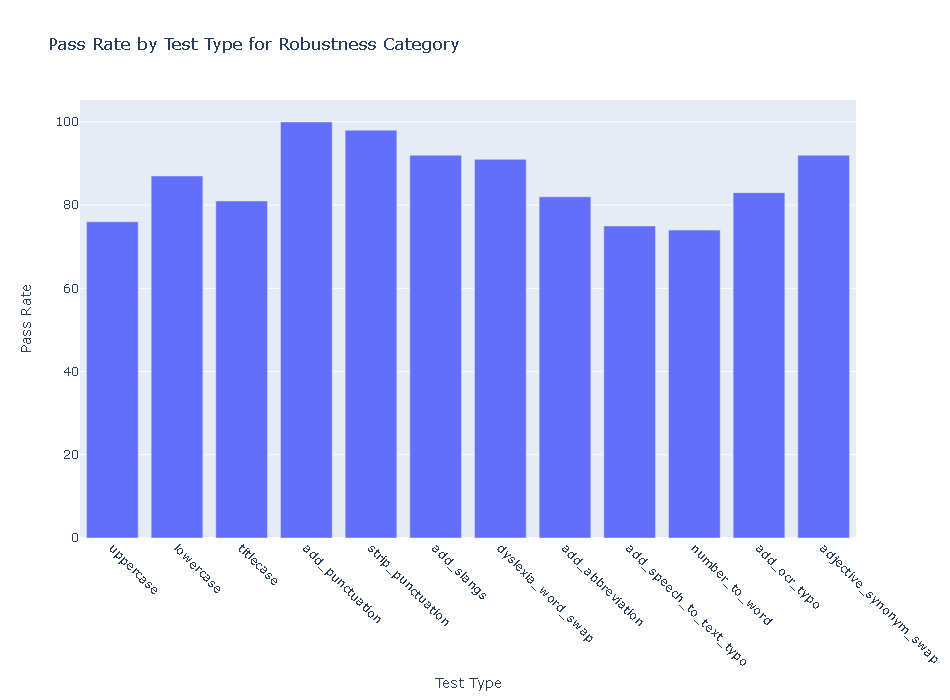

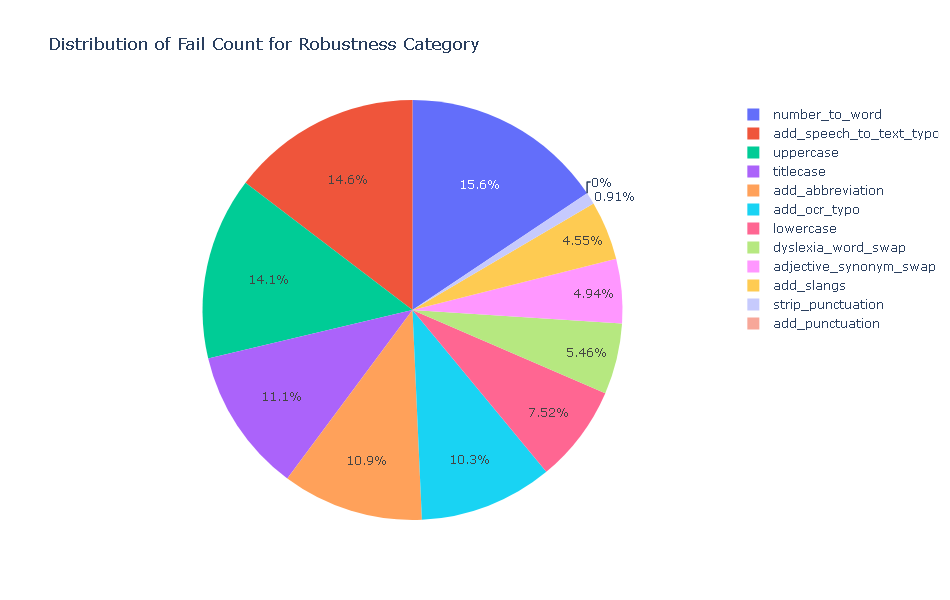

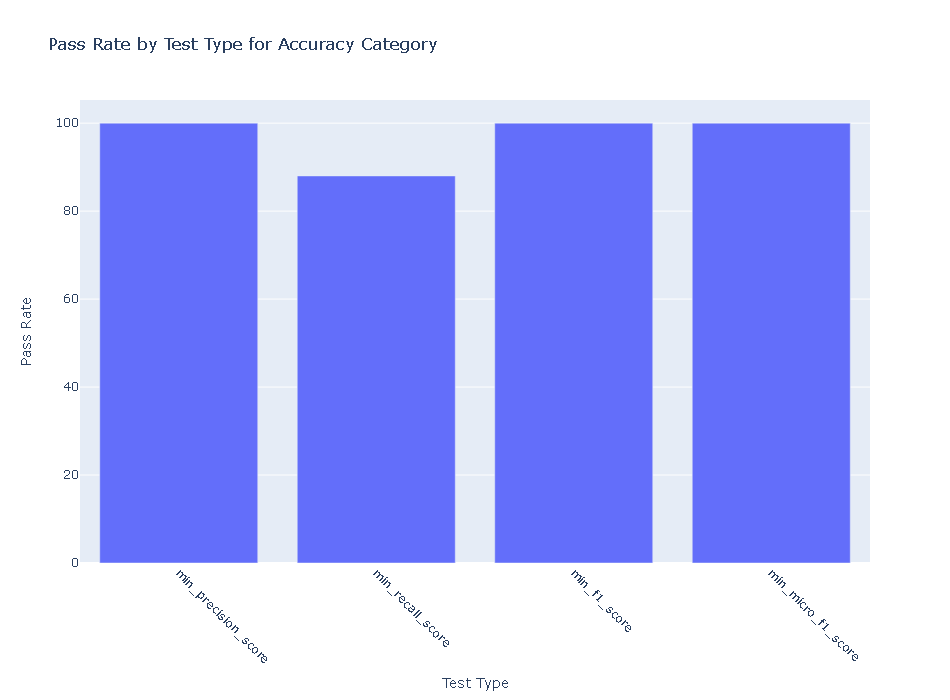

In [25]:
import plotly.express as px

# Get unique categories
report['pass_rate'] = report['pass_rate'].str.rstrip('%').astype(float)
report['minimum_pass_rate'] = report['minimum_pass_rate'].str.rstrip('%').astype(float)

# Get unique categories
# Get unique categories
unique_categories = report["category"].unique()

# Category 1: Robustness
category_data = report[report["category"] == "robustness"]

# Bar Plot: Pass Rate by Test Type for the Robustness Category
bar_fig = px.bar(category_data, x="test_type", y="pass_rate",
                 labels={"pass_rate": "Pass Rate", "test_type": "Test Type"},
                 title="Pass Rate by Test Type for Robustness Category")
bar_fig.update_xaxes(tickangle=45)
bar_fig.update_layout(width=1000, height=700)
bar_fig.show()

# Pie Chart: Distribution of Fail Count for the Robustness Category
pie_fig = px.pie(category_data, names="test_type", values="fail_count",
                 title="Distribution of Fail Count for Robustness Category")
pie_fig.update_layout(width=800, height=600)
pie_fig.show()

# Category 2: Accuracy
category_data = report[report["category"] == "accuracy"]

# Bar Plot: Pass Rate by Test Type for the Accuracy Category
bar_fig = px.bar(category_data, x="test_type", y="pass_rate",
                 labels={"pass_rate": "Pass Rate", "test_type": "Test Type"},
                 title="Pass Rate by Test Type for Accuracy Category")
bar_fig.update_xaxes(tickangle=45)
bar_fig.update_layout(width=1000, height=700)
bar_fig.show()

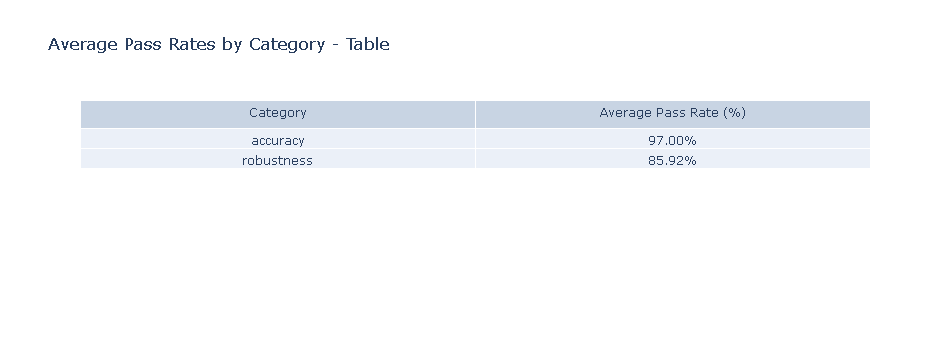

In [26]:
import plotly.graph_objects as go

avg_pass_rate_by_category = report.groupby('category')['pass_rate'].mean().reset_index()

# Create a table using Plotly
fig = go.Figure(data=[go.Table(
    header=dict(values=['Category', 'Average Pass Rate (%)']),
    cells=dict(values=[avg_pass_rate_by_category['category'], 
                       avg_pass_rate_by_category['pass_rate'].apply(lambda x: f'{x:.2f}%')]))
])

# Customize the layout
fig.update_layout(title='Average Pass Rates by Category - Table')

# Show the interactive table
fig.show()

## Testing Med7 model

#### Instantiate the Harness Class
We start by instantiating the Harness class and providing the necessary information for testing. In this case, we specify the test data, set the task to "ner", and provide the model name and hub information.

In [34]:
harness = Harness(
            task = "ner",
            data={"data_source":"sample-test.conll"},
            model={"model":"en_core_med7_lg","hub":"spacy"}
        )

Test Configuration : 
 {
 "tests": {
  "defaults": {
   "min_pass_rate": 1.0
  },
  "robustness": {
   "add_typo": {
    "min_pass_rate": 0.7
   },
   "american_to_british": {
    "min_pass_rate": 0.7
   }
  },
  "accuracy": {
   "min_micro_f1_score": {
    "min_score": 0.7
   }
  },
  "bias": {
   "replace_to_female_pronouns": {
    "min_pass_rate": 0.7
   },
   "replace_to_low_income_country": {
    "min_pass_rate": 0.7
   }
  },
  "fairness": {
   "min_gender_f1_score": {
    "min_score": 0.6
   }
  },
  "representation": {
   "min_label_representation_count": {
    "min_count": 50
   }
  }
 }
}


#### Configure the Tests
We can use the .configure() method to manually configure the tests we want to perform.

In [35]:
harness.configure(
{
 'tests': {'defaults': {'min_pass_rate': 0.70},
           'robustness': {'uppercase': {'min_pass_rate': 0.70},
                          'lowercase': {'min_pass_rate': 0.70},
                          'titlecase':{'min_pass_rate': 0.70},
                          'add_punctuation':{'min_pass_rate': 0.70},
                          'strip_punctuation':{'min_pass_rate': 0.70},
                          'add_slangs':{'min_pass_rate': 0.70},
                          'dyslexia_word_swap':{'min_pass_rate': 0.70},
                          'add_abbreviation':{'min_pass_rate': 0.70},
                          'add_speech_to_text_typo':{'min_pass_rate': 0.70},
                          'number_to_word':{'min_pass_rate': 0.70},
                          'add_ocr_typo':{'min_pass_rate': 0.70},
                          'adjective_synonym_swap':{'min_pass_rate': 0.70}
                        },
              'accuracy': {'min_precision_score': {'min_score': 0.70},
                          'min_recall_score':{'min_score': 0.70},
                        'min_f1_score':{'min_score': 0.70},
                        'min_micro_f1_score':{'min_score': 0.70}
                          }
          }
 }
)

{'tests': {'defaults': {'min_pass_rate': 0.7},
  'robustness': {'uppercase': {'min_pass_rate': 0.7},
   'lowercase': {'min_pass_rate': 0.7},
   'titlecase': {'min_pass_rate': 0.7},
   'add_punctuation': {'min_pass_rate': 0.7},
   'strip_punctuation': {'min_pass_rate': 0.7},
   'add_slangs': {'min_pass_rate': 0.7},
   'dyslexia_word_swap': {'min_pass_rate': 0.7},
   'add_abbreviation': {'min_pass_rate': 0.7},
   'add_speech_to_text_typo': {'min_pass_rate': 0.7},
   'number_to_word': {'min_pass_rate': 0.7},
   'add_ocr_typo': {'min_pass_rate': 0.7},
   'adjective_synonym_swap': {'min_pass_rate': 0.7}},
  'accuracy': {'min_precision_score': {'min_score': 0.7},
   'min_recall_score': {'min_score': 0.7},
   'min_f1_score': {'min_score': 0.7},
   'min_micro_f1_score': {'min_score': 0.7}}}}

Here we have configured the harness to perform robustness and Accuracy tests

#### Generating the test cases.

In [ ]:
harness.generate()

Generating testcases...: 100%|██████████| 2/2 [00:00<00:00, 14438.22it/s]


harness.generate() method automatically generates the test cases (based on the provided configuration)

In [ ]:
harness.testcases()

harness.testcases() method gives the produced test cases in form of a pandas data frame.

#### Running the tests

In [ ]:
harness.run()

Running testcases... : 100%|██████████| 18025/18025 [06:43<00:00, 44.70it/s]


Called after harness.generate() and is to used to run all the tests.  Returns a pass/fail flag for each test.

#### Generated Results

In [ ]:
harness.generated_results()

,category,test_type,original,test_case,expected_result,actual_result,pass
0,robustness,uppercase,"Once adequate arrhythmia control is achieved , or if side effects become prominent , reduce amiodarone hydrochloride dose to 600 to 800 mg/day for one month and then to the maintenance dose , usua...","ONCE ADEQUATE ARRHYTHMIA CONTROL IS ACHIEVED , OR IF SIDE EFFECTS BECOME PROMINENT , REDUCE AMIODARONE HYDROCHLORIDE DOSE TO 600 TO 800 MG/DAY FOR ONE MONTH AND THEN TO THE MAINTENANCE DOSE , USUA...","amiodarone hydrochloride: DRUG, 800 mg/: STRENGTH, day: FREQUENCY, for one month: DURATION, 400 mg/: STRENGTH, day: FREQUENCY",AMIODARONE HYDROCHLORIDE DOSE: DRUG,False
1,robustness,uppercase,One applicator full of VANDAZOLE administered intravaginally once a day for 5 days .,ONE APPLICATOR FULL OF VANDAZOLE ADMINISTERED INTRAVAGINALLY ONCE A DAY FOR 5 DAYS .,"One: DOSAGE, VANDAZOLE: DRUG, once a day: FREQUENCY, for 5 days: DURATION","VANDAZOLE: DRUG, FOR 5 DAYS: DURATION",False
2,robustness,uppercase,"Because of the potential for gastric irritation ( see WARNINGS ), Potassium Chloride Extended-release Capsules , USP , 8 mEq and 10 mEq should be taken with meals and with a full glass of water or...","BECAUSE OF THE POTENTIAL FOR GASTRIC IRRITATION ( SEE WARNINGS ), POTASSIUM CHLORIDE EXTENDED-RELEASE CAPSULES , USP , 8 MEQ AND 10 MEQ SHOULD BE TAKEN WITH MEALS AND WITH A FULL GLASS OF WATER OR...","Potassium Chloride: DRUG, USP: DRUG, 8 mEq: STRENGTH, 10 mEq: STRENGTH","USP: DRUG, 8: DOSAGE, MEQ: DRUG, 10: DOSAGE",False
3,robustness,uppercase,DOSAGE AND ADMINISTRATION : Selegiline hydrochloride capsules are intended for administration to Parkinsonian patients receiving levodopa/carbidopa therapy who demonstrate a deteriorating response...,DOSAGE AND ADMINISTRATION : SELEGILINE HYDROCHLORIDE CAPSULES ARE INTENDED FOR ADMINISTRATION TO PARKINSONIAN PATIENTS RECEIVING LEVODOPA/CARBIDOPA THERAPY WHO DEMONSTRATE A DETERIORATING RESPONSE...,"hydrochloride: DRUG, capsules: FORM, levodopa: DRUG, carbidopa: DRUG",,False
4,robustness,uppercase,Directions For sunscreen use : - apply liberally and evenly 15 minutes before sun exposure - reapply at least every 2 hours - use a water resistant sunscreen if swimming or sweating - Sun Protecti...,DIRECTIONS FOR SUNSCREEN USE : - APPLY LIBERALLY AND EVENLY 15 MINUTES BEFORE SUN EXPOSURE - REAPPLY AT LEAST EVERY 2 HOURS - USE A WATER RESISTANT SUNSCREEN IF SWIMMING OR SWEATING - SUN PROTECTI...,,,True
...,...,...,...,...,...,...,...
18020,accuracy,min_f1_score,-,DURATION,0.7,0.66426,False
18021,accuracy,min_f1_score,-,ROUTE,0.7,0.669291,False
18022,accuracy,min_f1_score,-,DOSAGE,0.7,0.357143,False
18023,accuracy,min_f1_score,-,FREQUENCY,0.7,0.771729,True


This method returns the generated results in the form of a pandas dataframe, which provides a convenient and easy-to-use format for working with the test results. You can use this method to quickly identify the test cases that failed and to determine where fixes are needed.

In [ ]:
df= harness.generated_results()

#### Generated Results For robustness

In [ ]:
df[df["category"]=="robustness"]

,category,test_type,original,test_case,expected_result,actual_result,pass
0,robustness,uppercase,"Once adequate arrhythmia control is achieved , or if side effects become prominent , reduce amiodarone hydrochloride dose to 600 to 800 mg/day for one month and then to the maintenance dose , usua...","ONCE ADEQUATE ARRHYTHMIA CONTROL IS ACHIEVED , OR IF SIDE EFFECTS BECOME PROMINENT , REDUCE AMIODARONE HYDROCHLORIDE DOSE TO 600 TO 800 MG/DAY FOR ONE MONTH AND THEN TO THE MAINTENANCE DOSE , USUA...","amiodarone hydrochloride: DRUG, 800 mg/: STRENGTH, day: FREQUENCY, for one month: DURATION, 400 mg/: STRENGTH, day: FREQUENCY",AMIODARONE HYDROCHLORIDE DOSE: DRUG,False
1,robustness,uppercase,One applicator full of VANDAZOLE administered intravaginally once a day for 5 days .,ONE APPLICATOR FULL OF VANDAZOLE ADMINISTERED INTRAVAGINALLY ONCE A DAY FOR 5 DAYS .,"One: DOSAGE, VANDAZOLE: DRUG, once a day: FREQUENCY, for 5 days: DURATION","VANDAZOLE: DRUG, FOR 5 DAYS: DURATION",False
2,robustness,uppercase,"Because of the potential for gastric irritation ( see WARNINGS ), Potassium Chloride Extended-release Capsules , USP , 8 mEq and 10 mEq should be taken with meals and with a full glass of water or...","BECAUSE OF THE POTENTIAL FOR GASTRIC IRRITATION ( SEE WARNINGS ), POTASSIUM CHLORIDE EXTENDED-RELEASE CAPSULES , USP , 8 MEQ AND 10 MEQ SHOULD BE TAKEN WITH MEALS AND WITH A FULL GLASS OF WATER OR...","Potassium Chloride: DRUG, USP: DRUG, 8 mEq: STRENGTH, 10 mEq: STRENGTH","USP: DRUG, 8: DOSAGE, MEQ: DRUG, 10: DOSAGE",False
3,robustness,uppercase,DOSAGE AND ADMINISTRATION : Selegiline hydrochloride capsules are intended for administration to Parkinsonian patients receiving levodopa/carbidopa therapy who demonstrate a deteriorating response...,DOSAGE AND ADMINISTRATION : SELEGILINE HYDROCHLORIDE CAPSULES ARE INTENDED FOR ADMINISTRATION TO PARKINSONIAN PATIENTS RECEIVING LEVODOPA/CARBIDOPA THERAPY WHO DEMONSTRATE A DETERIORATING RESPONSE...,"hydrochloride: DRUG, capsules: FORM, levodopa: DRUG, carbidopa: DRUG",,False
4,robustness,uppercase,Directions For sunscreen use : - apply liberally and evenly 15 minutes before sun exposure - reapply at least every 2 hours - use a water resistant sunscreen if swimming or sweating - Sun Protecti...,DIRECTIONS FOR SUNSCREEN USE : - APPLY LIBERALLY AND EVENLY 15 MINUTES BEFORE SUN EXPOSURE - REAPPLY AT LEAST EVERY 2 HOURS - USE A WATER RESISTANT SUNSCREEN IF SWIMMING OR SWEATING - SUN PROTECTI...,,,True
...,...,...,...,...,...,...,...
17995,robustness,adjective_synonym_swap,"The sooner you take emergency contraception , the better it works .","The sooner you take emergency contraception , the improved it works .",,,True
17996,robustness,adjective_synonym_swap,Omeprazole and esomeprazole significantly reduce the antiplatelet activity of Clopidogrel .,Omeprazole and esomeprazole significantly reduce the antiplatelet activity of Clopidogrel .,"Omeprazole: DRUG, esomeprazole: DRUG, Clopidogrel: DRUG","Omeprazole: DRUG, esomeprazole: DRUG, Clopidogrel: DRUG",True
17997,robustness,adjective_synonym_swap,DIRECTIONS FOR USE : Intramuscular Administration : Reconstitute ceftriaxone powder with the appropriate diluent ( see COMPATIBILITY AND STABILITY : ).,DIRECTIONS FOR USE : Intramuscular Administration : Reconstitute ceftriaxone powder with the convenient diluent ( see COMPATIBILITY AND STABILITY : ).,"Reconstitute: DRUG, ceftriaxone: DRUG, powder: FORM","Reconstitute: DRUG, ceftriaxone: DRUG, powder: FORM",True
17998,robustness,adjective_synonym_swap,2.4 Dosage Adjustment Patients with Rash Discontinue nevirapine if a patient experiences severe rash or any rash accompanied by constitutional findings [see Warnings and Precautions ( 5.2)] .,2.4 Dosage Adjustment Patients with Rash Discontinue nevirapine if a patient experiences serious bold or each bold accompanied by constitutional findings [see Warnings and Precautions ( 5.2)] .,nevirapine: DRUG,nevirapine: DRUG,True


#### Generated Results For accuracy

In [ ]:
df[df["category"]=="accuracy"]

,category,test_type,original,test_case,expected_result,actual_result,pass
18000,accuracy,min_precision_score,-,DRUG,0.7,0.8726,True
18001,accuracy,min_precision_score,-,O,0.7,0.948315,True
18002,accuracy,min_precision_score,-,FORM,0.7,0.836957,True
18003,accuracy,min_precision_score,-,STRENGTH,0.7,0.820327,True
18004,accuracy,min_precision_score,-,DURATION,0.7,0.779661,True
18005,accuracy,min_precision_score,-,ROUTE,0.7,0.858586,True
18006,accuracy,min_precision_score,-,DOSAGE,0.7,0.446429,False
18007,accuracy,min_precision_score,-,FREQUENCY,0.7,0.834711,True
18008,accuracy,min_recall_score,-,DRUG,0.7,0.69735,False
18009,accuracy,min_recall_score,-,O,0.7,0.977315,True


#### Report of the tests

In [ ]:
harness.report()

,category,test_type,fail_count,pass_count,pass_rate,minimum_pass_rate,pass
0,robustness,uppercase,907,593,40%,70%,False
1,robustness,lowercase,141,1359,91%,70%,True
2,robustness,titlecase,595,905,60%,70%,False
3,robustness,add_punctuation,11,1489,99%,70%,True
4,robustness,strip_punctuation,27,1473,98%,70%,True
5,robustness,add_slangs,99,1401,93%,70%,True
6,robustness,dyslexia_word_swap,166,1334,89%,70%,True
7,robustness,add_abbreviation,337,1163,78%,70%,True
8,robustness,add_speech_to_text_typo,493,1007,67%,70%,False
9,robustness,number_to_word,422,1078,72%,70%,True


Called after harness.run() and it summarizes the results giving information about pass and fail counts and overall test pass/fail flag.

In [74]:
# saving the report in the form of csv
report=harness.report()
report.to_csv("report_med7.csv",index=False)

#### Visualizing the Report

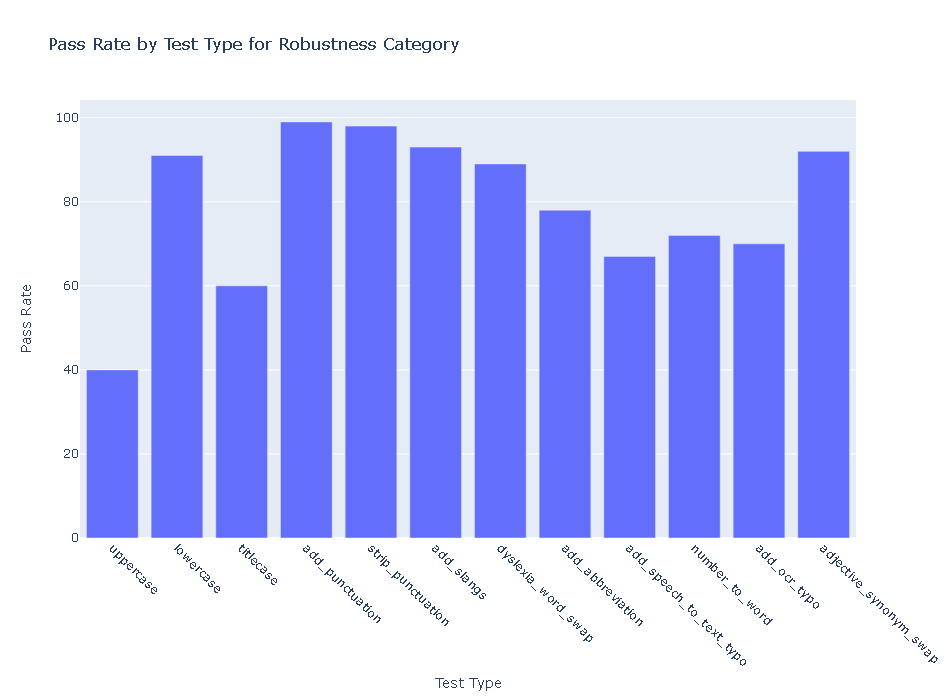

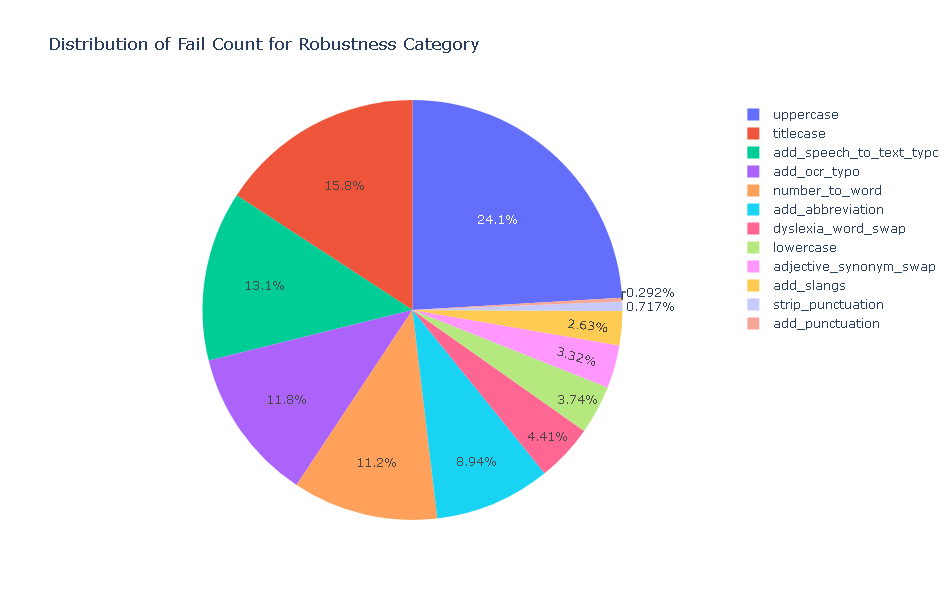

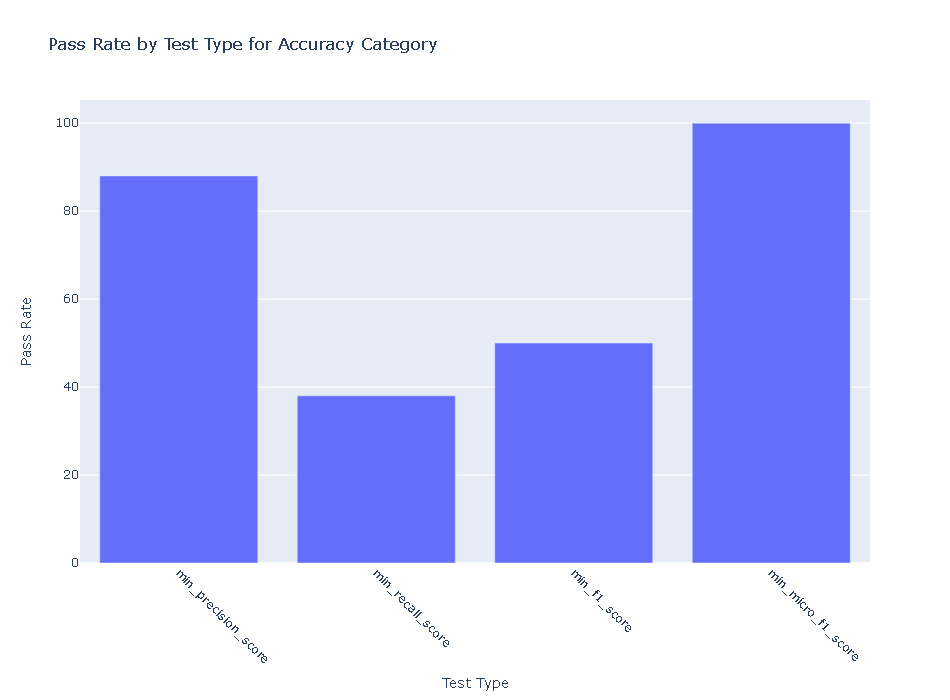

In [22]:
import plotly.express as px

# Get unique categories
report['pass_rate'] = report['pass_rate'].str.rstrip('%').astype(float)
report['minimum_pass_rate'] = report['minimum_pass_rate'].str.rstrip('%').astype(float)

# Get unique categories
# Get unique categories
unique_categories = report["category"].unique()

# Category 1: Robustness
category_data = report[report["category"] == "robustness"]

# Bar Plot: Pass Rate by Test Type for the Robustness Category
bar_fig = px.bar(category_data, x="test_type", y="pass_rate",
                 labels={"pass_rate": "Pass Rate", "test_type": "Test Type"},
                 title="Pass Rate by Test Type for Robustness Category")
bar_fig.update_xaxes(tickangle=45)
bar_fig.update_layout(width=1000, height=700)
bar_fig.show()

# Pie Chart: Distribution of Fail Count for the Robustness Category
pie_fig = px.pie(category_data, names="test_type", values="fail_count",
                 title="Distribution of Fail Count for Robustness Category")
pie_fig.update_layout(width=800, height=600)
pie_fig.show()

# Category 2: Accuracy
category_data = report[report["category"] == "accuracy"]

# Bar Plot: Pass Rate by Test Type for the Accuracy Category
bar_fig = px.bar(category_data, x="test_type", y="pass_rate",
                 labels={"pass_rate": "Pass Rate", "test_type": "Test Type"},
                 title="Pass Rate by Test Type for Accuracy Category")
bar_fig.update_xaxes(tickangle=45)
bar_fig.update_layout(width=1000, height=700)
bar_fig.show()

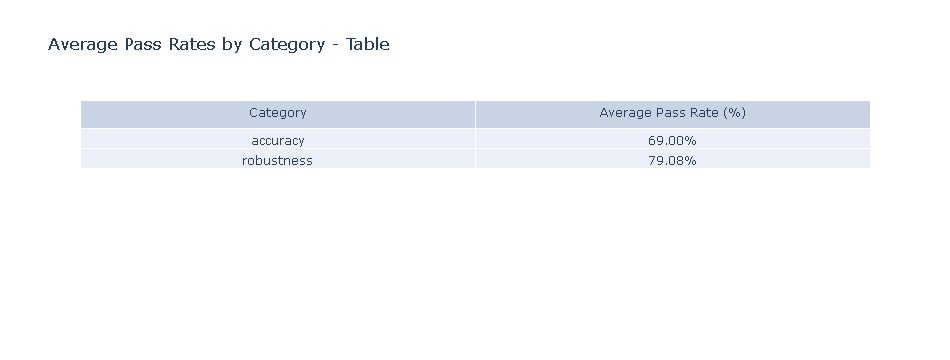

In [23]:
import plotly.graph_objects as go

avg_pass_rate_by_category = report.groupby('category')['pass_rate'].mean().reset_index()

# Create a table using Plotly
fig = go.Figure(data=[go.Table(
    header=dict(values=['Category', 'Average Pass Rate (%)']),
    cells=dict(values=[avg_pass_rate_by_category['category'], 
                       avg_pass_rate_by_category['pass_rate'].apply(lambda x: f'{x:.2f}%')]))
])

# Customize the layout
fig.update_layout(title='Average Pass Rates by Category - Table')

# Show the interactive table
fig.show()

## Comparing Models 

comparing the results of `ner_posology_langtest` from JSL and `med7` from spacy.

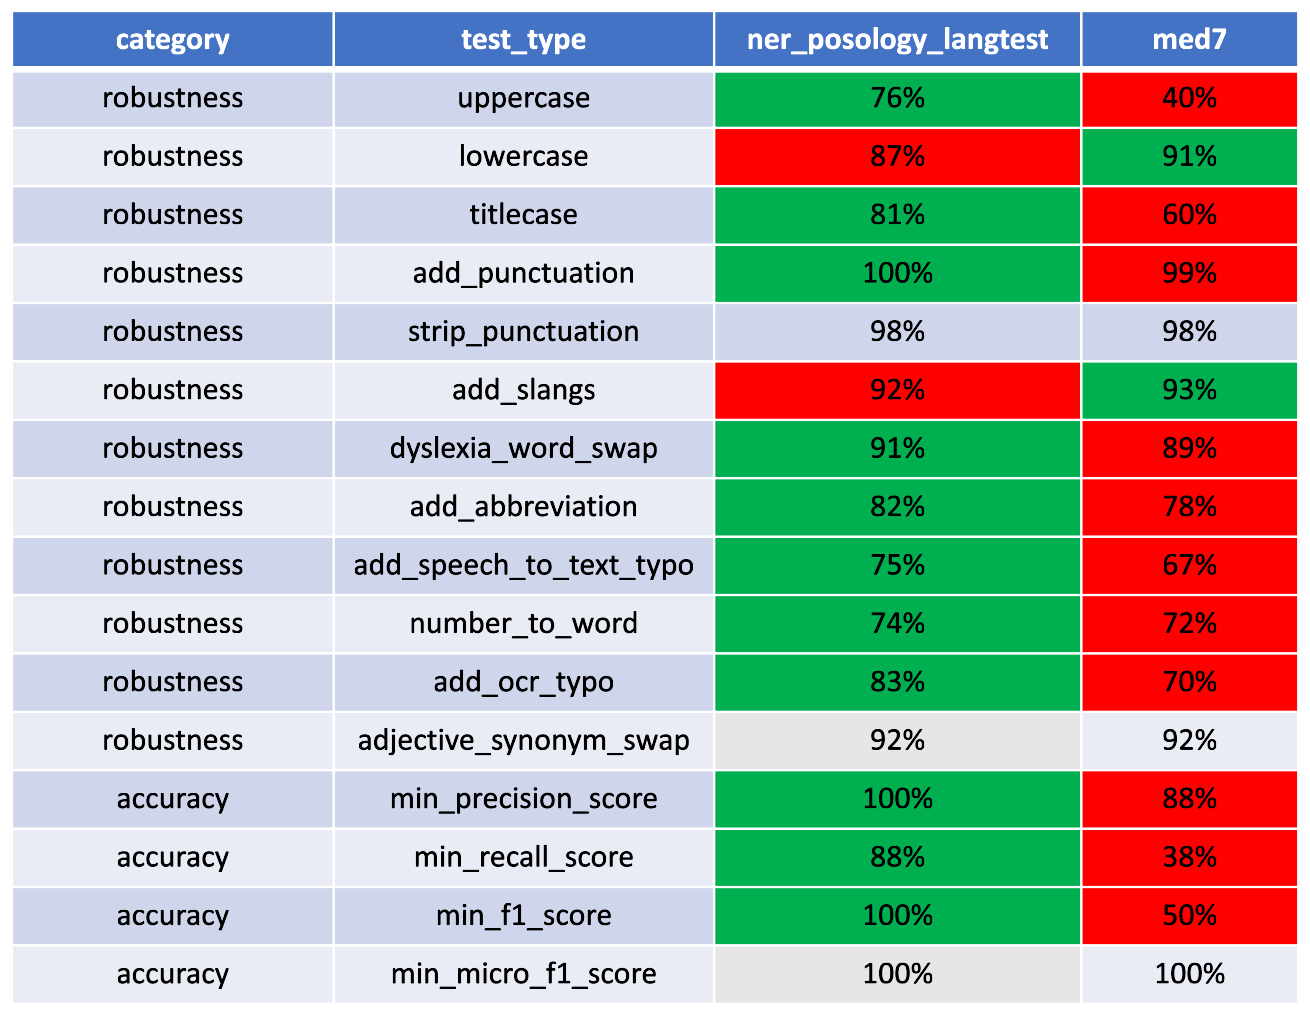

After evaluating the performance of the ner posology and med7 models in terms of Robustness, and Accuracy, here are the findings:

- **Accuracy**: The ner_posology model demonstrated exceptional accuracy, achieving a perfect pass rate across all accuracy-related tests. In contrast, the med7 model exhibited weaknesses, with failures observed in precision, recall, and F1 score tests.
- **Robustness**: In terms of robustness, the ner posology model outperformed the med7 model in most test categories. This indicates the ner posology model’s ability to effectively handle a wider range of inputs, highlighting its superior robustness.

## Conclusion
In conclusion, while accuracy is undoubtedly crucial, robustness testing takes natural language processing (NLP) models evaluation to the next level by ensuring that models can perform reliably and consistently across a wide array of real-world conditions.

To further enhance the performance of these models, it is crucial to address any identified weaknesses. One potential solution is to consider augmenting the training set using langtest. By incorporating langtest for augmentation, we can potentially improve the models’ generalization and adaptability to diverse patterns and contexts.

To explore the implementation of langtest for augmentation, I recommend referring to the [Generating Augmentations](https://langtest.org/docs/pages/docs/generate_augmentation) section of the langtest website. This approach may lead to more robust models that can deliver even better results in various applications.